In [1]:
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="0"

In [2]:
#import statements
import sys
import random
import warnings
import numpy as np
import pandas as pd

import tensorflow as tf
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline


from itertools import chain

from skimage.transform import resize
from skimage.morphology import label
from skimage.io import imread, imshow, imread_collection, concatenate_images

from keras import backend as K
from keras.layers import Input
from keras.preprocessing import image
from keras.layers.merge import concatenate
from keras.models import Model, load_model
from keras.layers.core import Dropout, Lambda
from keras.layers.pooling import MaxPooling2D
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.layers.convolutional import Conv2D, Conv2DTranspose


np.random.seed(10)
tf.set_random_seed(4422)

warnings.filterwarnings('ignore', category=UserWarning, module='skimage')

/N/u/gautham4/.local/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [3]:
config = tf.ConfigProto()
config.gpu_options.allow_growth = True
config.gpu_options.per_process_gpu_memory_fraction = 0.33
sess = tf.InteractiveSession(config = config)

In [4]:
train_path = '/N/u/priyadarshini/project/Nucleaidetection/data/data/stage1_train/'
test_path = '/N/u/priyadarshini/project/Nucleaidetection/data/data/stage1_test/'

###  1. Data Preprocessing

In [5]:
#Getting the ids
train_ids = next(os.walk(train_path))[1]
test_ids = next(os.walk(test_path))[1]

In [6]:
#Loading the Parameters
batch_size = 10
image_width = 128
image_height = 128
channels = 3

In [7]:
#Resizing the images
X_train = np.zeros((len(train_ids), image_height, image_width, channels), dtype=np.uint8)
Y_train = np.zeros((len(train_ids), image_height, image_width, 1), dtype=np.bool)
for i, id_ in enumerate(train_ids):
    img = imread(train_path + id_ + '/images/' + id_ + '.png')[:,:,:channels]
    X_train[i] = resize(img, (image_height, image_width), mode='constant', preserve_range=True)
    combined_mask = np.zeros((image_height, image_width, 1), dtype=np.bool)
    for file in next(os.walk(train_path + id_ + '/masks/'))[2]:
        mask = imread(train_path + id_  + '/masks/' + file)
        mask = np.expand_dims(resize(mask, (image_height, image_width), mode='constant', 
                                      preserve_range=True), axis=-1)
        combined_mask = np.maximum(combined_mask, mask)
    Y_train[i] = combined_mask
print('Resized the train images and masks.')

Resized the train images and masks.


In [8]:
X_test = np.zeros((len(test_ids), image_height, image_width, channels), dtype=np.uint8)
sizes_test = []
for i, id_ in enumerate(test_ids):
    img = imread(test_path + id_ + '/images/' + id_ + '.png')[:,:,:channels]
    sizes_test.append([img.shape[0], img.shape[1]])
    X_test[i] = resize(img, (image_height, image_width), mode='constant', preserve_range=True)

print('Resized the test images')

Resized the test images


In [9]:
import numpy as np 

def RLE_encoding_to_mask(rle_line,height,width):
  rows,cols = height,width
  rleNumbers = [int(numstring) for numstring in rle_line.split(' ')]
  rle_p = np.array(rleNumbers).reshape(-1,2)
  img = np.zeros(rows*cols,dtype=np.uint8)
  for index,length in rle_p:
    index -= 1
    img[index:index+length] = 255
  img = img.reshape(cols,rows)
  img = img.T
  return img

In [10]:
test_df = pd.read_csv('/N/u/priyadarshini/project/Nucleaidetection/data/data/stage1_solution.csv')

print('Creating Test masks...')

Y_test = np.zeros((len(train_ids), image_height, image_width, 1), dtype=np.bool)
for n, id_ in enumerate(test_ids):
   mask = np.zeros((image_height, image_width, 1), dtype=np.bool)
   df = test_df.loc[test_df['ImageId'] == id_]
   
   for i in range (0,(df).shape[0]) :
         mask_ = RLE_encoding_to_mask(df.iloc[i,1],256,256)
         mask_ = np.expand_dims(resize(mask_, (image_height, image_width), mode='constant', 
                                      preserve_range=True), axis=-1)
         mask = np.maximum(mask, mask_)
   Y_test[n] = mask


print('Done')



Creating Test masks...
Done


###  2. Data Augmentation

In [11]:
# Images and Mask generators
image_datagen = image.ImageDataGenerator(shear_range=0.5, rotation_range=50, zoom_range=0.2, width_shift_range=0.2, height_shift_range=0.2, fill_mode='reflect')
mask_datagen = image.ImageDataGenerator(shear_range=0.5, rotation_range=50, zoom_range=0.2, width_shift_range=0.2, height_shift_range=0.2, fill_mode='reflect')

image_datagen_val = image.ImageDataGenerator()
mask_datagen_val = image.ImageDataGenerator()

image_datagen.fit(X_train[:int(X_train.shape[0]*0.9)], augment=True, seed=56)
mask_datagen.fit(Y_train[:int(Y_train.shape[0]*0.9)], augment=True, seed=56)

image_datagen_val.fit(X_train[int(X_train.shape[0]*0.9):], augment=True, seed=56)
mask_datagen_val.fit(Y_train[int(Y_train.shape[0]*0.9):], augment=True, seed=56)

x=image_datagen.flow(X_train[:int(X_train.shape[0]*0.9)],batch_size=batch_size,shuffle=True, seed=56)
y=mask_datagen.flow(Y_train[:int(Y_train.shape[0]*0.9)],batch_size=batch_size,shuffle=True, seed=56)

x_val=image_datagen_val.flow(X_train[int(X_train.shape[0]*0.9):],batch_size=batch_size,shuffle=True, seed=56)
y_val=mask_datagen_val.flow(Y_train[int(Y_train.shape[0]*0.9):],batch_size=batch_size,shuffle=True, seed=56)

train_generator = zip(x, y)
val_generator = zip(x_val, y_val)

In [12]:
def iou_metric(true, pred, print_table=False):
    true = label(true > 0.5)
    pred = label(pred > 0.5)
    i = np.histogram2d(true.flatten(), pred.flatten(), bins=(len(np.unique(true)), len(np.unique(pred))))[0]#intersection of true and prediction
    ta = np.histogram(true, bins = len(np.unique(true)))[0] #Area of true label
    pa = np.histogram(pred, bins = len(np.unique(pred)))[0] #Area of predicted label
    u = np.expand_dims(ta, -1) + np.expand_dims(pa, 0) - i  # true+pred-intersection
    i = i[1:,1:]
    u = u[1:,1:]
    u[u == 0] = 1e-9
    precisions = []   
    for threshold in np.arange(0.5, 1.0, 0.05):
        tp = np.sum(np.sum(((i/u) > threshold), axis=1) == 1) #true positive
        fp = np.sum(np.sum(((i/u) > threshold), axis=0) == 0) #false positive
        fn = np.sum(np.sum(((i/u) > threshold), axis=1) == 0) #false negative
        precisions.append(tp / (tp + fp + fn) if (tp + fp + fn) > 0 else 0)            
    return np.mean(precisions)

def iou_metric_batch(true, pred):
    metric = [iou_metric(true[i], pred[i]) for i in range(true.shape[0])]
    return np.array(np.mean(metric), dtype=np.float32)

def mean_iou(true, pred):
    return tf.py_func(iou_metric_batch, [true, pred], tf.float32)

###  3. Link-net

In [13]:
from keras.models import Model
from keras.layers import Input, Conv2D, Deconv2D, MaxPool2D, concatenate, AvgPool2D
network_mode = 'bn'
s_c2 = lambda fc, k, s = 1, activation='elu', **kwargs: Conv2D(fc, kernel_size = (k,k), strides= (s,s),
                                       padding = 'same', activation = activation,**kwargs)


s_d2 = lambda fc, k, s = 1, activation='elu', **kwargs: Deconv2D(fc, kernel_size=(k,k), strides=(s,s), 
                                                       padding = 'same', activation=activation, **kwargs)


if network_mode == 'bn':
    
    
    from keras.layers import BatchNormalization, Activation
    
    c2 = lambda fc, k, s = 1, **kwargs: lambda x: Activation('elu')(BatchNormalization()(
        Conv2D(fc, kernel_size = (k,k), strides= (s,s),
               padding = 'same', activation = 'linear', **kwargs)(x)))

    d2 = lambda fc, k, s = 1, **kwargs: lambda x: Activation('elu')(BatchNormalization()(
        Deconv2D(fc, kernel_size=(k,k), strides=(s,s), 
                 padding = 'same', activation='linear', **kwargs)(x)))
else:
    c2 = s_c2
    d2 = s_d2

In [14]:
# Build Link-Net model
start_in = Input((image_height, image_width,channels), name = 'Input')
start_scale = Lambda(lambda x: x / 255) (start_in)
# pre-processing
in_filt = c2(64, 7, 2)(start_scale)
in_mp = MaxPool2D((3,3), strides = (2,2), padding = 'same')(in_filt)

In [29]:
from keras import backend as K
from keras.regularizers import l2
from keras.layers import add

def link(input, residual):

    input_shape = K.int_shape(input)
    residual_shape = K.int_shape(residual)
    stride_width = int(round(input_shape[1] / residual_shape[1]))
    stride_height = int(round(input_shape[2] / residual_shape[2]))
    equal_channels = input_shape[3] == residual_shape[3]

    link_ = input
    # 1 X 1 conv if shape is different. Else identity.
    if stride_width > 1 or stride_height > 1 or not equal_channels:
        link_ = Conv2D(filters=residual_shape[3],
                          kernel_size=(1, 1),
                          strides=(stride_width, stride_height),
                          padding="valid",
                          kernel_initializer="he_normal",
                          kernel_regularizer=l2(0.0001))(input)

    return add([link_, residual])

def enc_block(m, n):
    def block_func(x):
        cx = c2(n, 3)(c2(n, 3, 2)(x))
        cs1 = concatenate([AvgPool2D((2,2))(x), 
                           cx])
        cs2 = c2(n, 3)(c2(n, 3)(cs1))
        return concatenate([cs2, cs1])
    return block_func
def dec_block(m, n):
    def block_func(x):
        cx1 = c2(m//4, 1)(x)
        cx2 = d2(m//4, 3, 2)(cx1)
        return Dropout(0.1)(c2(n, 1)(cx2))
    return block_func

In [30]:
enc1 = enc_block(64, 64)(in_mp)
enc2 = enc_block(64, 128)(enc1)

dec2 = dec_block(64, 128)(enc2)
dec2_cat = link(enc1, dec2)
dec1 = dec_block(64, 64)(dec2_cat)

last_out = link(dec1, in_mp)

In [31]:
# post-processing
out_upconv = d2(32, 3, 2)(last_out)
out_conv = c2(32, 3)(out_upconv)
out = s_d2(1, 2, 2, activation = 'sigmoid')(out_conv)

In [32]:
from keras import backend as K
from keras.metrics import binary_crossentropy
smooth = 1.

def dice_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)
def bce_dice(y_true, y_pred):
    return binary_crossentropy(y_true, y_pred)-K.log(dice_coef(y_true, y_pred))

In [33]:
model = Model(inputs = [start_in], outputs = [out])    
model.compile(optimizer = 'adam', 
              loss = bce_dice, 
              metrics = ['binary_crossentropy', dice_coef, mean_iou])

In [34]:
model_DA = Model(inputs = [start_in], outputs = [out])    
model_DA.compile(optimizer = 'adam', 
              loss = bce_dice, 
              metrics = ['binary_crossentropy', dice_coef, mean_iou])

In [35]:
# Fit model
earlystopper = EarlyStopping(patience=5, verbose=1)
checkpointer = ModelCheckpoint('Link-Net-model-dsbowl2018-1.h5', verbose=1, save_best_only=True)
results = model.fit(X_train, Y_train, 
                    validation_split=0.1, 
                    batch_size=16, epochs=100, 
                    callbacks=[earlystopper, checkpointer])

Train on 603 samples, validate on 67 samples
Epoch 1/100
603/603 [==============================] - 9s 14ms/step - loss: 1.5692 - binary_crossentropy: 0.5798 - dice_coef: 0.3879 - mean_iou: 0.0208 - val_loss: 0.9663 - val_binary_crossentropy: 0.3677 - val_dice_coef: 0.5611 - val_mean_iou: 0.0520

Epoch 00001: val_loss improved from inf to 0.96627, saving model to Link-Net-model-dsbowl2018-1.h5
Epoch 2/100
603/603 [==============================] - 4s 6ms/step - loss: 1.0981 - binary_crossentropy: 0.4085 - dice_coef: 0.5170 - mean_iou: 0.0735 - val_loss: 0.9755 - val_binary_crossentropy: 0.4494 - val_dice_coef: 0.6029 - val_mean_iou: 0.0832

Epoch 00002: val_loss did not improve
Epoch 3/100
603/603 [==============================] - 4s 6ms/step - loss: 0.8578 - binary_crossentropy: 0.3124 - dice_coef: 0.5952 - mean_iou: 0.1379 - val_loss: 0.5643 - val_binary_crossentropy: 0.1950 - val_dice_coef: 0.7046 - val_mean_iou: 0.2024

Epoch 00003: val_loss improved from 0.96627 to 0.56429, savin

In [22]:
# Fitting the model with Augmented Data
earlystopper_DA = EarlyStopping(patience=5, verbose=1)
checkpointer_DA = ModelCheckpoint('Link-Net-with-data-augmentation-model-dsbowl2018-1.h5', verbose=1, save_best_only=True)
results_DA = model_DA.fit_generator(train_generator, validation_data=val_generator, validation_steps=10, steps_per_epoch=250,
                              epochs=50, callbacks=[earlystopper_DA, checkpointer_DA])

Epoch 1/50
250/250 [==============================] - 19s 76ms/step - loss: 0.4181 - binary_crossentropy: 0.1597 - dice_coef: 0.7867 - mean_iou: 0.3036 - val_loss: 0.4038 - val_binary_crossentropy: 0.1367 - val_dice_coef: 0.7778 - val_mean_iou: 0.3440

Epoch 00001: val_loss improved from inf to 0.40381, saving model to Link-Net-with-data-augmentation-model-dsbowl2018-1.h5
Epoch 2/50
250/250 [==============================] - 17s 67ms/step - loss: 0.3828 - binary_crossentropy: 0.1436 - dice_coef: 0.8012 - mean_iou: 0.3333 - val_loss: 0.3818 - val_binary_crossentropy: 0.1378 - val_dice_coef: 0.7943 - val_mean_iou: 0.3434

Epoch 00002: val_loss improved from 0.40381 to 0.38180, saving model to Link-Net-with-data-augmentation-model-dsbowl2018-1.h5
Epoch 3/50
250/250 [==============================] - 17s 68ms/step - loss: 0.3495 - binary_crossentropy: 0.1307 - dice_coef: 0.8144 - mean_iou: 0.3483 - val_loss: 0.3152 - val_binary_crossentropy: 0.1107 - val_dice_coef: 0.8246 - val_mean_iou: 0

In [25]:
no_aug_model = 'Link-Net-model-dsbowl2018-1.h5'
aug_model = 'Link-Net-with-data-augmentation-model-dsbowl2018-1.h5'

In [26]:
def display_predicted_images(model_name):    

    # Predicting on train, val and test using models that we built 
    best_model = load_model(model_name, custom_objects={'mean_iou': mean_iou}, compile = False)
    preds_train = best_model.predict(X_train[:int(X_train.shape[0]*0.9)])
    preds_val = best_model.predict(X_train[int(X_train.shape[0]*0.9):])
    preds_test = best_model.predict(X_test)

    preds_train_t = (preds_train > 0.5).astype(np.uint8)
    preds_val_t = (preds_val > 0.5).astype(np.uint8)
    preds_test_t = (preds_test > 0.5).astype(np.uint8)

    # Create list of upsampled test masks
    preds_test_upsampled = []
    for i in range(len(preds_test)):
        preds_test_upsampled.append(resize(np.squeeze(preds_test[i]),(sizes_test[i][0], sizes_test[i][1]), 
                                       mode='constant', preserve_range=True))
    
    
    # Checking the predictions on training samples.
    ix = random.randint(0, len(preds_train_t))
    imshow(X_train[ix])
    plt.show()
    imshow(np.squeeze(Y_train[ix]))
    plt.show()
    imshow(np.squeeze(preds_train_t[ix]))
    plt.show()


    # Checking the predictions on validation samples.
    ix = random.randint(0, len(preds_val_t))
    imshow(X_train[int(X_train.shape[0]*0.9):][ix])
    plt.show()
    imshow(np.squeeze(Y_train[int(Y_train.shape[0]*0.9):][ix]))
    plt.show()
    imshow(np.squeeze(preds_val_t[ix]))
    plt.show()
    

def display_results(model_name) :
    # Predicting on train, val and test using models that we built 
    best_model = load_model(model_name, custom_objects={'mean_iou': mean_iou}, compile = False)
    preds_train = best_model.predict(X_train[:int(X_train.shape[0]*0.9)])
    preds_val = best_model.predict(X_train[int(X_train.shape[0]*0.9):])
    preds_test = best_model.predict(X_test)

    preds_train_t = (preds_train > 0.5).astype(np.uint8)
    preds_val_t = (preds_val > 0.5).astype(np.uint8)
    preds_test_t = (preds_test > 0.5).astype(np.uint8)

    # Create list of upsampled test masks
    preds_test_upsampled = []
    for i in range(len(preds_test)):
        preds_test_upsampled.append(resize(np.squeeze(preds_test[i]),(sizes_test[i][0], sizes_test[i][1]), 
                                       mode='constant', preserve_range=True))
    
    
    
    print('Results for'+model_name+'\n\n')
    iou = []
    for i in range(0,603):
        iou.append(iou_metric(np.squeeze(Y_train[i]), np.squeeze(preds_train_t[i])))
    iou = np.asarray(iou)
    print('Train Mean Precision Score')
    print(iou.mean(),"\n")
    
    
    
    iou_val = []
    for i in range(0,67):
        iou_val.append(iou_metric(np.squeeze(Y_train[i+603]), np.squeeze(preds_val_t[i])))
    iou_val = np.asarray(iou_val)
    print('Validation Mean Precision Score')
    print(iou_val.mean(), "\n")
    
    
    
    iou_t = []
    for i in range(0,65):
        iou_t.append(iou_metric(np.squeeze(Y_test[i]), np.squeeze(preds_test_t[i])))
    iou_t = np.asarray(iou_t)
    print('Test Mean Precision Score')
    print(iou_t.mean(), "\n")
    

/N/u/gautham4/.local/lib/python3.6/site-packages/skimage/io/_plugins/matplotlib_plugin.py:51: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  out_of_range_float = (np.issubdtype(image.dtype, np.float) and


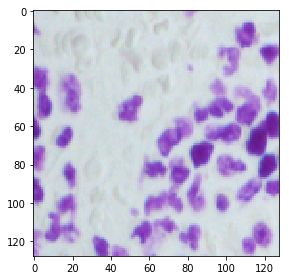

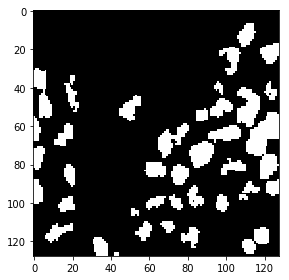

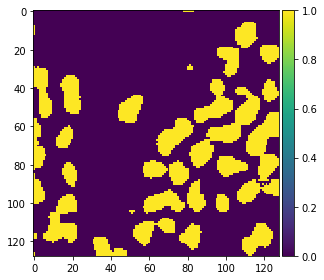

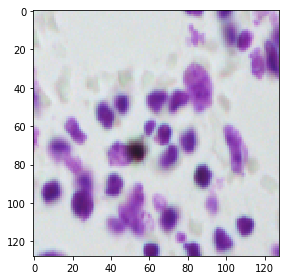

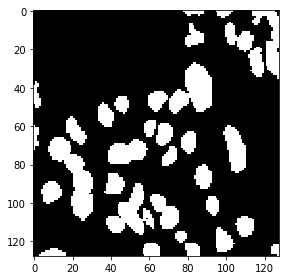

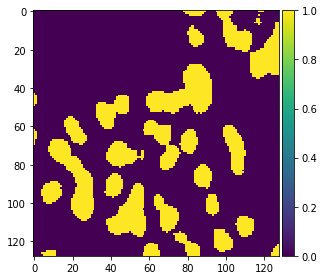

In [36]:
display_predicted_images(aug_model)

In [27]:
display_results(no_aug_model)

Results forLink-Net-model-dsbowl2018-1.h5


Train Mean Precision Score
0.5234931597408444 

Validation Mean Precision Score
0.5100541891797492 

Test Mean Precision Score
0.20194224310901407 



In [28]:
display_results(aug_model)

Results forLink-Net-with-data-augmentation-model-dsbowl2018-1.h5


Train Mean Precision Score
0.5004060064785506 

Validation Mean Precision Score
0.4912528625603593 

Test Mean Precision Score
0.22491252762666078 

